In [41]:
from copy import deepcopy
import os, json, cv2, random, pathlib, shutil
import numpy as np
import matplotlib.pyplot as plt


def random_color() -> list:
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]


def multiply_odds_evens(lst, x, y):
    for i in range(len(lst)):
        if i % 2 == 0:  # even index
            lst[i] *= x
        else:  # odd index
            lst[i] *= y
    return lst


def draw_polygons(img_filename, polygons, texts, thickness=1):
    img = cv2.imread(img_filename)

    height = img.shape[0]
    width = img.shape[1]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tl = thickness
    tf = max(tl - 1, 1)
    for p, text in zip(polygons, texts):
        multiply_odds_evens(p, width, height)
        color = random_color()
        pts_x = p[::2]
        pts_y = p[1::2]
        pts = [[x, y] for x, y in zip(pts_x, pts_y)]
        pts = np.array(pts, np.int32)

        # draw ploygon lines
        cv2.polylines(img, [pts], isClosed=True, thickness=thickness, color=color)

        # draw polygon mask
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, pts=[pts], color=color)
        _mask = deepcopy(mask)
        _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2GRAY)
        area = cv2.countNonZero(_mask)
        alpha = 0.5
        img = cv2.addWeighted(img, 1, mask, alpha, 0)

        # bounding box format: (tlx, tly, w, h)
        x, y, w, h = cv2.boundingRect(pts)
        # print(f"After conversion: x: {x}, y:{y}, w:{w}, h:{h}")
        cv2.rectangle(
            img,
            pt1=(x, y),
            pt2=(x + w, y + h),
            color=color,
            thickness=thickness,
            lineType=cv2.LINE_AA,
        )
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=thickness)[0]
        c1 = (x, y)
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(
            img, c1, c2, color=color, thickness=-1, lineType=cv2.LINE_AA
        )  # filled
        cv2.putText(
            img,
            text,
            (c1[0], c1[1] - 2),
            0,
            tl / 3,
            [255, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )
    return img, area

[74, 93, 31, 44, 40, 82, 83]


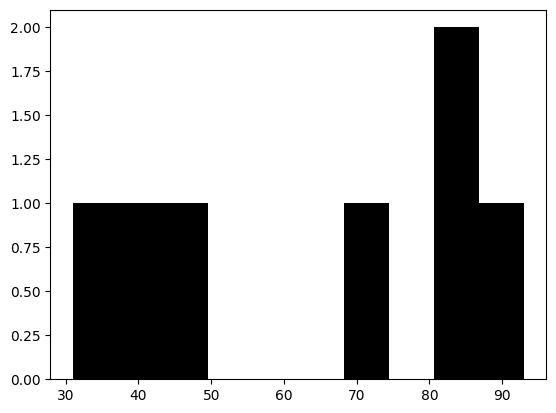

In [42]:
data_dir = "/mnt/linux/abrc/abrc/dataset/stomaVDP/2023-all-337"
img_dir = os.path.join(data_dir, "images", "val")
label_dir = os.path.join(data_dir, "labels", "val")

output_dir = "../outputs/"
isExist = os.path.exists(output_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(output_dir)
    print("output directory is created!")

# load image names
ext_map = {}
imgs = os.listdir(img_dir)
# extract file extension into a map
for img in imgs:
    img_name, img_ext = os.path.splitext(img)
    ext_map[img_name] = img_ext

areas = []

# load label names
labels = os.listdir(label_dir)
for label in labels:
    lines = []
    polygons = []
    texts = []

    file_name, _ = os.path.splitext(label)
    # Read polygon annotations from a label file
    with open(os.path.join(label_dir, label), "r") as f:
        lines = f.readlines()

    # prepare polygons and texts
    for i, line in enumerate(lines):
        chars = line.split(" ")
        chars = list(map(float, chars))
        polygons.append(chars[1:])
        texts.append("stomata ")

    img_file = os.path.join(img_dir, file_name + ext_map[file_name])
    img, area = draw_polygons(img_file, polygons, texts, thickness=2)

    if area < 100:
        areas.append(area)

    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # fig = plt.figure(figsize=(12, 8), dpi=300)
    # plt.axis("off")
    # plt.title("test")
    # plt.imshow(img)
    plt.imsave(os.path.join(output_dir, file_name + ".png"), img)
    # plt.close(fig)

plt.hist(areas, color="black")
print(areas)